# NLP - MP
### Objetivos:
1. Levantar un PDF
2. Convertirlo a texto plano
3. separar en corpus, oraciones y palabras
4. Quitar palabras inútiles (stopwords) y medir frecuencia de las palabras
5. Nube de palabras
6. Evaluar sentimiento de las oraciones con VADER y TextBlob
7. Realizar esquema de lemmatizacion Stemming

In [4]:
#! python -m spacy download es_dep_news_trf
#! pip install spacy
#! pip install pdfminer
#!pip install wordcloud
#!pip install textblob
import warnings
warnings.filterwarnings('ignore')

#Importamos las librerías tradicionales
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importamos librerias específicas para NLP
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud#,STOPWORDS

# Elegimos las stopwords en español. Pedimos que muestre cuántas hay (313)
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download("vader_lexicon")
stop_words = set(stopwords.words('spanish')) 

import re


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mparada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mparada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mparada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mparada\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mparada\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1. Levantar el PDF

In [5]:
# Levantamos el PDF
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage, PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams
from io import StringIO
import io 
 
class PDFUtils():
 
    def __init__(self):
        pass
 
    def pdf2txt(self, path):
        output = io.StringIO()
        with open(path, 'rb') as f:
            praser = PDFParser(f)
            doc = PDFDocument(praser)
            if not doc.is_extractable:
                raise PDFTextExtractionNotAllowed
            pdfrm = PDFResourceManager()
            laparams = LAParams()
            device = PDFPageAggregator(pdfrm, laparams=laparams)
            interpreter = PDFPageInterpreter(pdfrm, device)
            for page in PDFPage.create_pages(doc):
                interpreter.process_page(page)
                layout = device.get_result()
                for x in layout:
                    if hasattr(x, "get_text"):
                        content = x.get_text()
                        output.write(content)
 
        content = output.getvalue()
        output.close()
        return content

if __name__ == '__main__':
    path = u'/informe.pdf'
    pdf_utils = PDFUtils()

### 2. Convertimos en texto plano y lo guardamos en corpus

In [6]:
#Guardamos el informe como txt en "informe"
data = pdf_utils.pdf2txt('informe.pdf')

In [7]:
#Verificamos que se haya guardado el texto
data[:500]

'[Escribir texto] \n \nINFORME DE AUDITORÍA INDEPENDIENTE \nSOBRE LOS ESTADOS FINANCIEROS DEL \n“PROYECTO DE DESARROLLO SUSTENTABLE \n DE LA CUENCA MATANZA-RIACHUELO” \nCONVENIO DE PRÉSTAMO BIRF N° 7706-AR  \n(Ejercicio N° 10 finalizado el 31/12/2020) \n \nAl Señor Subsecretario de Relaciones Financieras Internacionales para el Desarrollo \nde la Secretaría de Asuntos Estratégicos de la Presidencia de la Nación. \n \nLa Auditoría General de la Nación, en su carácter de auditor externo independiente, ha exami'

### 3. Separamos(tokenizamos) en corpus, párrafos (sent_tokenize) y palabras (word_tokenize)

In [8]:
#Corpus
corpus=data
#Tokenizamos oraciones con sent_tokenize
oraciones = sent_tokenize(corpus)
#Tokenizamos palabras con sent_tokenize
palabras = word_tokenize(corpus)

### Chequeamos oraciones y palabras

In [9]:
print(palabras[:5])
print(oraciones[:5])

['[', 'Escribir', 'texto', ']', 'INFORME']
['[Escribir texto] \n \nINFORME DE AUDITORÍA INDEPENDIENTE \nSOBRE LOS ESTADOS FINANCIEROS DEL \n“PROYECTO DE DESARROLLO SUSTENTABLE \n DE LA CUENCA MATANZA-RIACHUELO” \nCONVENIO DE PRÉSTAMO BIRF N° 7706-AR  \n(Ejercicio N° 10 finalizado el 31/12/2020) \n \nAl Señor Subsecretario de Relaciones Financieras Internacionales para el Desarrollo \nde la Secretaría de Asuntos Estratégicos de la Presidencia de la Nación.', 'La Auditoría General de la Nación, en su carácter de auditor externo independiente, ha examinado \nlos estados financieros, sus notas anexas e información financiera complementaria por el ejercicio \nfinalizado el 31/12/2020 detallados en I- siguiente, correspondientes al “Proyecto de Desarrollo \nSustentable de la Cuenca Matanza-Riachuelo”, actualmente financiado con recursos provenientes \ndel Convenio de Préstamo N° 7706-AR, suscripto el 25/08/2009 entre la Nación Argentina y el \nBanco Internacional de Reconstrucción y Fomento 

### Chequeamos frecuencia de palabras convirtiendo en un DataFrame y utilizando value_counts()

In [10]:
palabras_df = pd.DataFrame(palabras,columns=['palabra'])
#Vemos los primeros 10 registos
palabras_df['palabra'].value_counts().head(10)

de     627
.      331
la     320
,      297
el     279
en     224
y      199
del    183
que    165
a      138
Name: palabra, dtype: int64

### 4. Depurar y quitar palabras inútiles (stopwords) y medir la frecuencia

Como vemos, las palabras mas frecuentes son palabras neutras para nuestro análisis, la gran mayoría símbolos de puntuación y preposiciones, por lo que vamos a utilizar un conjunto de palabras neutras llamadas stopwords para restarselas al DataFrame:

In [11]:
#stop_words

In [12]:
#Primero convertimos todo a minúsculas
palabras = [x.lower() for x in palabras]
# Eliminamos caracteres de puntuación y no alfanuméricos con isalnum()
palabras = [w for w in palabras if w.isalnum()]
#Ahora si guardamos lo que no se encuentre en STOP_WORDS (se sugiere ver el contenido de stopwords para evitar falsos positivos)
palabras = [w for w in palabras if not w in stop_words]
#Convertimos en DataFrame para utilizar nuevamente value_counts()
palabras_df = pd.DataFrame(palabras,columns=['palabra'])
#Vemos los primeros 10 registos
palabras_df['palabra'].value_counts().head(20)

proyecto         59
préstamo         47
ejercicio        41
cuenta           31
usd              30
aysa             30
parte            30
birf             29
obra             28
auditoría        27
obras            26
ucgp             24
sistema          23
auditor          22
convenio         22
desarrollo       21
nación           20
control          20
ejecución        20
documentación    20
Name: palabra, dtype: int64

### 5. Nube de palabras

In [13]:
#palabras

(-0.5, 399.5, 199.5, -0.5)

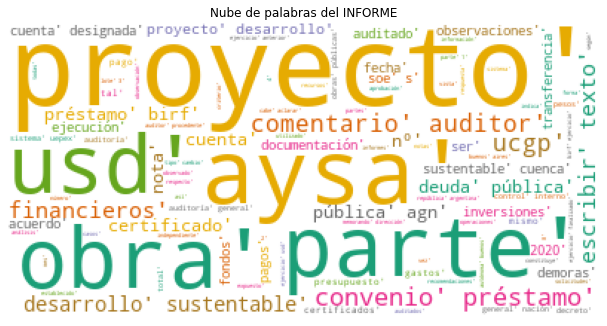

In [14]:
# Convertimos la lista palabras a string para utilizar la función WordCloud
wc=str(palabras)
#Generamos la nube de palabras
word_cloud = WordCloud(background_color="white", colormap="Dark2",max_font_size=200, random_state=42).generate(wc)
#Mostramos la Nube de palabras
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('Nube de palabras del INFORME')
ax1.imshow(word_cloud)
ax1.axis('off')

### 6. Evaluar sentimiento de las oraciones
Conertimos en un DataFrame las oraciones, agregaremos una columna para el largo de cada párrafo

In [15]:
#Primero convertimos todo a minúsculas
oraciones = [x.lower() for x in oraciones]    
# Eliminamos caracteres de puntuación y no alfanuméricos con isalnum()
# A agregar

In [16]:
oraciones_df = pd.DataFrame(oraciones,columns=['oracion'])
#Creamos la columna largo con el largo del parrafo en chars
oraciones_df['largo'] = oraciones_df['oracion'].apply(len)
oraciones_df.head()

,oracion,largo
0,[escribir texto] \n \ninforme de auditoría ind...,404
1,"la auditoría general de la nación, en su carác...",572
2,la ejecución del proyecto actualmente es ...,273
3,i- \n \nestados auditados \n \n1- estado de ...,150
4,"2- estado de inversiones por apertura, de...",116


### Analizamos sentimiento utilizando la librería VADER

In [17]:
%%time
### Analizando el sentimiento con VADER
sia = SentimentIntensityAnalyzer()
# aplicamoc vader para asignar un valor positivo, negativo, neutro y un compuesto que integra todos
oraciones_df["neg"] = oraciones_df["oracion"].apply(lambda x:sia.polarity_scores(x)["neg"])
oraciones_df["pos"] = oraciones_df["oracion"].apply(lambda x:sia.polarity_scores(x)["pos"])
oraciones_df["neu"] = oraciones_df["oracion"].apply(lambda x:sia.polarity_scores(x)["neu"])
oraciones_df["compuesto"] = oraciones_df["oracion"].apply(lambda x:sia.polarity_scores(x)["compound"])

CPU times: total: 328 ms
Wall time: 312 ms


In [18]:
positivas = oraciones_df.sort_values("compuesto", ascending=False).head(10)
negativas = oraciones_df.sort_values("compuesto", ascending=True).head(10)

In [19]:
sia.polarity_scores("los actos demuestran que las obras no fueron realizadas.")

{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'compound': -0.296}

In [20]:
#Negativas
negativas.head()

,oracion,largo,neg,pos,neu,compuesto
161,"cabe \ndestacar que, no se tuvo ninguna eviden...",414,0.164,0.0,0.836,-0.8860
260,como se mencionó anteriormente es correcto que...,536,0.116,0.0,0.884,-0.8481
186,a.3.1.2 las operaciones que originan la ...,611,0.093,0.0,0.907,-0.7906
115,el \ndecreto que designa al ministerio de...,391,0.114,0.0,0.886,-0.7430
21,"los faltantes \nque fueron solicitados, en alg...",231,0.158,0.0,0.842,-0.7003


In [21]:
#Positivas
positivas.head()

,oracion,largo,neg,pos,neu,compuesto
209,"a su vez, en otro caso indica una transferenci...",197,0.0,0.088,0.912,0.4215
65,(agn: corresponde al estado de la cuenta desig...,285,0.0,0.049,0.951,0.3400
63,"la auditoría general de la nación, en su carác...",456,0.0,0.036,0.964,0.3400
1,"la auditoría general de la nación, en su carác...",572,0.0,0.033,0.967,0.3400
205,"de acuerdo a los organigramas suministrados, s...",334,0.0,0.034,0.966,0.1280


### 7. Realizar esquema de Lemm y Stemm

In [22]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [23]:
print("Cantidad de palabras: ",len(palabras))
lem=[lemmatizer.lemmatize(x,pos='v') for x in palabras]
print("\nLematización: OK - palabras totales", len(lem))
stem=[stemmer.stem(x) for x in palabras]
print("\nAplicando stemming: OK - palabras totales", len(stem))
alpha=[x.lower() for x in stem if x.isalpha()]
print("\nFiltrando no-palabras y pasando a minuscula: OK - palabras totales", len(alpha))

Cantidad de palabras:  4232

Lematización: OK - palabras totales 4232

Aplicando stemming: OK - palabras totales 4232

Filtrando no-palabras y pasando a minuscula: OK - palabras totales 4038


In [24]:
pd.DataFrame(alpha).value_counts().head(20)

proyecto       61
obra           54
préstamo       47
ejercicio      44
cuenta         37
part           36
usd            30
aysa           30
birf           29
comentario     29
certificado    27
auditoría      27
nota           26
control        26
sistema        25
ucgp           24
pública        24
pago           23
auditor        23
convenio       22
dtype: int64

(-0.5, 399.5, 199.5, -0.5)

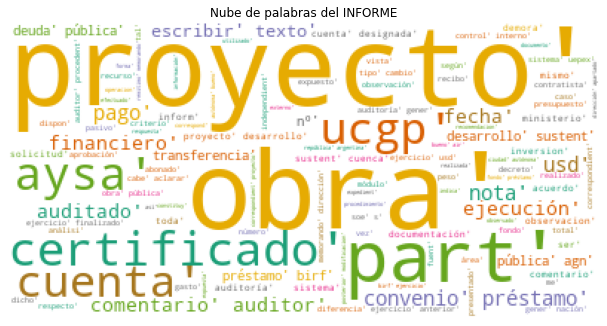

In [25]:
### Repetimos la nube de palabras luego de Stemm y LEmm
# Convertimos la lista palabras a string para utilizar la función WordCloud
wc=str(alpha)
#Generamos la nube de palabras
word_cloud = WordCloud(background_color="white", colormap="Dark2",max_font_size=200, random_state=42).generate(wc)
#Mostramos la Nube de palabras
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('Nube de palabras del INFORME')
ax1.imshow(word_cloud)
ax1.axis('off')

### Resumiendo el informe:

In [26]:
# Removing Square Brackets and Extra Spaces
#corpus = re.sub(r'\[[0-9]*\]', ' ', corpus)  
#corpus = re.sub(r'\s+', ' ', corpus)  

In [27]:
#corpus = re.sub('[^a-zA-Z]', ' ', corpus )  
#corpus = re.sub(r'\s+', ' ', corpus)  

In [28]:
sentence_list = nltk.sent_tokenize(corpus)  

In [29]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [30]:
word_frequencies = {}  
for word in nltk.word_tokenize(corpus):  
    if word not in stopwords:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1
            
maximum_frequncy = max(word_frequencies.values())

for word in word_frequencies.keys():  
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    
sentence_scores = {}  

for sent in sentence_list:  
    for word in nltk.word_tokenize(sent.lower()):
        if word in word_frequencies.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]
                    
import heapq  
summary_sentences = heapq.nlargest(20, sentence_scores, key=sentence_scores.get)
summary = ' '.join(summary_sentences)  
print(summary)  

CIUDAD AUTÓNOMA DE BUENOS AIRES, 02 de diciembre de 2021. Liliana E. RONCHI 
Cdor. Dra. Juan Manuel SADIR 
Lic. (Comentario  del  auditor:  No  procedente. El procedimiento tal como se encuentra implementado no prevé la suscripción de un acta 
entre las partes, como así un acto administrativo, llámese resolución o disposición, que lo 
apruebe. 3- Estado de Fuentes y Usos de Fondos (EFyU) o Flujo de Efectivo del Proyecto, desde el 
01/01/2020 al 31/12/2020, expresado en dólares estadounidenses. En la Nota Nº 20, (iii), tercer párrafo indica "Decreto 771/2020" donde debe decir "Decreto 
772/2020". Pagado en el ejercicio $ 5.404.433,65/ USD 96.507,74. El Decreto 772/2020, que formalizó dicha derivación, 
se emitió seis meses después (25/09/2020). Se toma nota. (Comentario  del  auditor:  No 
procedente. (Comentario 
del auditor: No procedente. A su vez, del total abonado durante el año 
por esta obra, las redeterminaciones pagadas constituyen casi el 75%. Obras:  "RC005  LOTE  3:  EMISARI

In [31]:
### Aplicamos TextBlob para polaridad y subjetividad
from textblob import TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [32]:
oraciones_df['subjectivity'] = oraciones_df['oracion'].map(getSubjectivity)
oraciones_df['polarity'] = oraciones_df['oracion'].map(getPolarity)

In [33]:
oraciones_df.head()

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
0,[escribir texto] \n \ninforme de auditoría ind...,404,0.0,0.000,1.000,0.00,0.0,0.00
1,"la auditoría general de la nación, en su carác...",572,0.0,0.033,0.967,0.34,0.5,0.05
2,la ejecución del proyecto actualmente es ...,273,0.0,0.000,1.000,0.00,0.5,0.05
3,i- \n \nestados auditados \n \n1- estado de ...,150,0.0,0.000,1.000,0.00,0.0,0.00
4,"2- estado de inversiones por apertura, de...",116,0.0,0.000,1.000,0.00,0.0,0.00


In [34]:
positivas_subj = oraciones_df.sort_values("subjectivity", ascending=False).head(5)
negativas_subj = oraciones_df.sort_values("subjectivity", ascending=True).head(5)

In [35]:
positivas_subj.head()

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
99,"existencia de documentación faltante que, al s...",253,0.115,0.0,0.885,-0.5267,1.00,0.00
21,"los faltantes \nque fueron solicitados, en alg...",231,0.158,0.0,0.842,-0.7003,1.00,0.00
269,la nota al pie del estado de inversiones en pe...,127,0.095,0.0,0.905,-0.2960,1.00,0.25
74,cabe destacar que el requerimiento de auditorí...,384,0.040,0.0,0.960,-0.2960,1.00,-0.80
282,"a su vez, existe una diferencia no significati...",133,0.099,0.0,0.901,-0.2960,0.75,0.00


In [36]:
negativas_subj.head()

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
0,[escribir texto] \n \ninforme de auditoría ind...,404,0.000,0.0,1.000,0.0000,0.0,0.0
221,22 \n[escribir texto] \n \n(aysa) desde el pri...,141,0.000,0.0,1.000,0.0000,0.0,0.0
220,"por \notra parte, la vinculación del proy...",186,0.122,0.0,0.878,-0.5574,0.0,0.0
219,(comentario del auditor: no \nse tuvo a la vis...,112,0.109,0.0,0.891,-0.2960,0.0,0.0
218,b.1.4 (ucgp) con respecto a los puestos vacan...,153,0.000,0.0,1.000,0.0000,0.0,0.0


In [37]:
positivas_pol = oraciones_df.sort_values("polarity", ascending=False).head(5)
negativas_pol = oraciones_df.sort_values("polarity", ascending=True).head(5)

In [38]:
positivas_pol.head()

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
269,la nota al pie del estado de inversiones en pe...,127,0.095,0.0,0.905,-0.2960,1.000000,0.250000
120,a.1.5 las operaciones del subejecutor aysa n...,218,0.073,0.0,0.927,-0.2960,0.300000,0.200000
215,"b.1.3 (ucgp) sobre el punto particular, ...",249,0.124,0.0,0.876,-0.5267,0.333333,0.166667
211,las designaciones fueron realizadas a \nef...,179,0.091,0.0,0.909,-0.2960,0.650000,0.150000
113,las designaciones fueron realizadas a \nef...,179,0.091,0.0,0.909,-0.2960,0.650000,0.150000


In [39]:
negativas_pol.head()

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
74,cabe destacar que el requerimiento de auditorí...,384,0.04,0.000,0.960,-0.296,1.00,-0.800
65,(agn: corresponde al estado de la cuenta desig...,285,0.00,0.049,0.951,0.340,0.75,-0.375
0,[escribir texto] \n \ninforme de auditoría ind...,404,0.00,0.000,1.000,0.000,0.00,0.000
225,la \ntransferencia n°542 se desafecta por tran...,61,0.00,0.000,1.000,0.000,0.00,0.000
224,la transferencia n°523 \nse corresponde con la...,108,0.00,0.000,1.000,0.000,0.00,0.000


In [40]:
### Unimos todos los DataFrames de analisis de sentimiento
datos = pd.concat([positivas_subj, negativas_subj,positivas_pol,negativas_pol])

In [41]:
datos

,oracion,largo,neg,pos,neu,compuesto,subjectivity,polarity
99,"existencia de documentación faltante que, al s...",253,0.115,0.000,0.885,-0.5267,1.000000,0.000000
21,"los faltantes \nque fueron solicitados, en alg...",231,0.158,0.000,0.842,-0.7003,1.000000,0.000000
269,la nota al pie del estado de inversiones en pe...,127,0.095,0.000,0.905,-0.2960,1.000000,0.250000
74,cabe destacar que el requerimiento de auditorí...,384,0.040,0.000,0.960,-0.2960,1.000000,-0.800000
282,"a su vez, existe una diferencia no significati...",133,0.099,0.000,0.901,-0.2960,0.750000,0.000000
0,[escribir texto] \n \ninforme de auditoría ind...,404,0.000,0.000,1.000,0.0000,0.000000,0.000000
221,22 \n[escribir texto] \n \n(aysa) desde el pri...,141,0.000,0.000,1.000,0.0000,0.000000,0.000000
220,"por \notra parte, la vinculación del proy...",186,0.122,0.000,0.878,-0.5574,0.000000,0.000000
219,(comentario del auditor: no \nse tuvo a la vis...,112,0.109,0.000,0.891,-0.2960,0.000000,0.000000
218,b.1.4 (ucgp) con respecto a los puestos vacan...,153,0.000,0.000,1.000,0.0000,0.000000,0.000000


In [43]:
#Guardamos en Excel
datos.to_excel('NLP_calificacion_parrafos_informe.xlsx')

# TF - IDF
Frecuencia de terminos y Frecuencia inversa de términos

In [ ]:
'''
!pip install 
numpy~=1.18
scikit-learn~=0.22
gensim~=3.8
nltk~=3.4
jupyterlab
'''
from tfidf import rank_documents

document_scores = rank_documents(search_terms, documents)